In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [247]:
df = pd.read_csv('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/results/output.csv')

df.replace('ni', 'ic', inplace=True)

def clean_combination(row):
    heuristic = row['heuristic']
    local_search = row['local_search']
    if local_search == 'none':
        return heuristic
    elif heuristic == 'none':
        return local_search
    else:
        return heuristic + '+' + local_search

df['combination'] = df.apply(clean_combination, axis=1)

# Reorden de columnas
cols = list(df.columns)
if 'combination' in cols and 'num_clientes' in cols:
    cols.remove('combination')
    idx = cols.index('num_clientes') + 1
    cols = cols[:idx] + ['combination'] + cols[idx:]
    df = df[cols]

# df_ok va a tener los casos que tienen soluciones factibles
df_ok = df[df['status'] == 'ok'].copy()

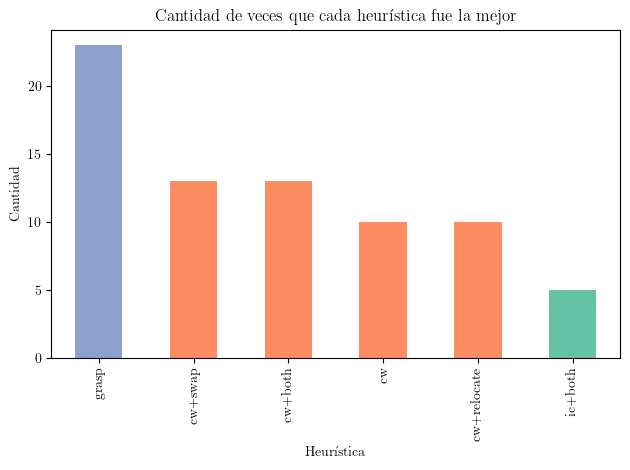

In [248]:
# Para cada instancia, encontrar todas las filas con el costo mínimo entre las soluciones factibles (manejar empates)
best_counts = {}

for instance, group in df_ok.groupby('instance'):
    # Asegurarse de que 'cost' sea numérico y no NaN
    group = group[pd.to_numeric(group['cost'], errors='coerce').notnull()]
    if group.empty:
        continue
    min_cost = group['cost'].min()
    winners = group[group['cost'] == min_cost]['combination']
    for comb in winners:
        best_counts[comb] = best_counts.get(comb, 0) + 1

# Convertir a Series para graficar
best_counts_series = pd.Series(best_counts).sort_values(ascending=False)

# Asignar un color para cada heurística base
base_colors = {
    'cw': '#fc8d62',      # naranja
    'ic': '#66c2a5',      # verde
    'grasp': '#8da0cb',   # azul
    'other': '#7f7f7f'    # gris
}

def get_family(combination):
    if combination.startswith('cw'):
        return 'cw'
    elif combination.startswith('ic'):
        return 'ic'
    elif combination.startswith('grasp'):
        return 'grasp'
    else:
        return 'other'

# Construir la lista de colores para cada barra
bar_colors = [base_colors.get(get_family(comb), base_colors['other']) for comb in best_counts_series.index]

# Graficar
best_counts_series.plot(kind='bar', color=bar_colors)
plt.title('Cantidad de veces que cada heurística fue la mejor')
plt.xlabel('Heurística')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.savefig('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/graficos/1.png', dpi=300)
plt.show()

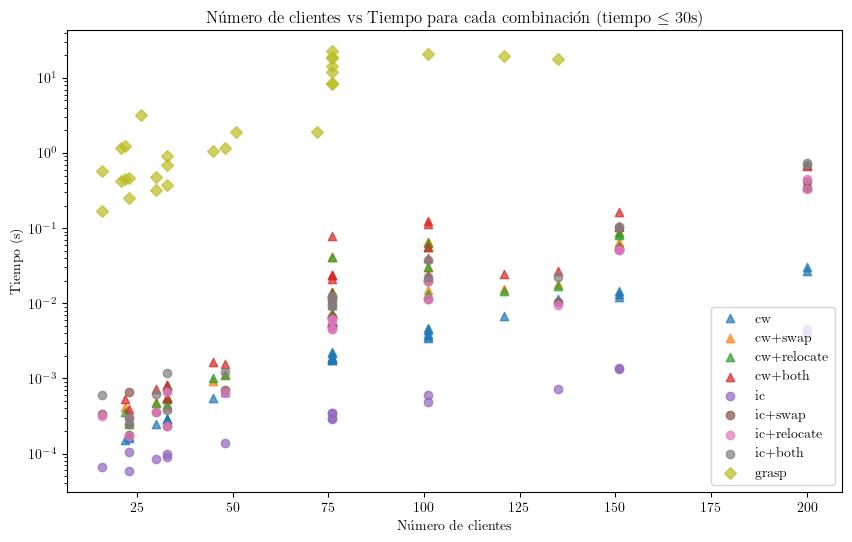

In [249]:
# Graficar tiempo vs número de clientes con diferentes formas para cw, ic, grasp
# Usamos solo aquellos que tardaron menos de 30s

plt.figure(figsize=(10,6))

# Filtrar solo aquellos con tiempo < 30s
df_fast = df_ok[df_ok['time'] < 30]

# Definir formas de marcador para cada familia (hacerlas diferentes)
marker_map = {
    'cw': '^',      # triángulo hacia arriba
    'ic': 's',      # cuadrado
    'grasp': 'D',   # diamante
    'ic': 'o',      # círculo
    'other': 'x'    # x para cualquier otro
}

# Asignar un marcador para cada combinación, usando diferentes formas para cada familia
for combination in df_fast['combination'].unique():
    subset = df_fast[df_fast['combination'] == combination]
    family = get_family(combination)
    marker = marker_map.get(family, marker_map['other'])  # por defecto 'x' si no se encuentra
    plt.scatter(subset['num_clientes'], subset['time'], label=combination, alpha=0.7, marker=marker)

plt.yscale('log')
plt.xlabel('Número de clientes')
plt.ylabel('Tiempo (s)')
plt.title(f'Número de clientes vs Tiempo para cada combinación (tiempo $\leq$ 30s)')
plt.legend()
plt.savefig('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/graficos/2.png', dpi=300)
plt.show()

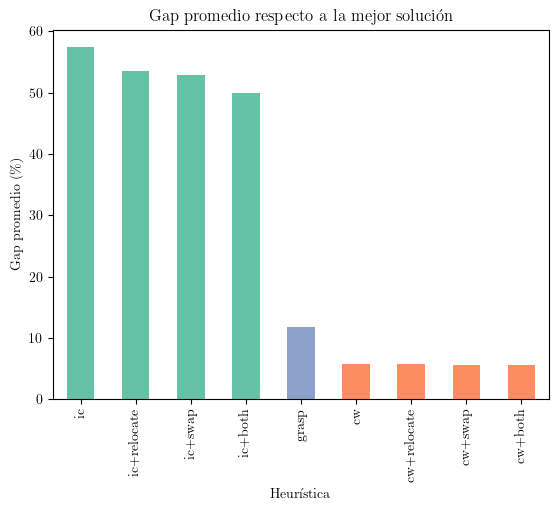

In [250]:
# Considerar solo filas donde 'gap' y 'best_known' no son NaN
df_gap = df_ok.dropna(subset=['gap', 'best_known'])

# Calcular el gap promedio por combinación
avg_gap = df_gap.groupby('combination')['gap'].mean()

# Ordenar de mayor a menor
avg_gap = avg_gap.sort_values(ascending=False)

# Construir la lista de colores para cada barra
bar_colors = [base_colors.get(get_family(comb), base_colors['other']) for comb in avg_gap.index]

# Graficar
avg_gap.plot(kind='bar', color=bar_colors)
plt.title('Gap promedio respecto a la mejor solución')
plt.xlabel('Heurística')
plt.ylabel('Gap promedio ($\%$)')
plt.savefig('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/graficos/3.png', dpi=300)
plt.show()

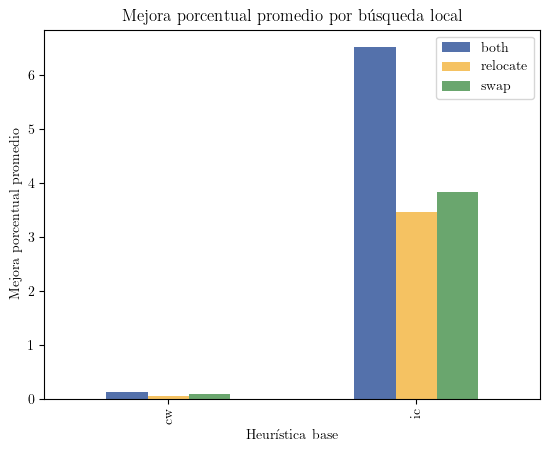

In [251]:
# Para cada heurística base, para cada instancia, comparar 'none' vs 'swap', 'relocate', 'both'
improvements = []
# Extraer la heurística base de la combinación (antes de '+')
df_ok['base_heuristic'] = df_ok['combination'].str.split('+').str[0]

for base_heuristic in df_ok['base_heuristic'].unique():
    for instance in df_ok['instance'].unique():
        base = df_ok[
            (df_ok['base_heuristic'] == base_heuristic) &
            (df_ok['instance'] == instance) &
            (df_ok['local_search'] == 'none')
        ]
        for ls in ['swap', 'relocate', 'both']:
            improved = df_ok[
                (df_ok['base_heuristic'] == base_heuristic) &
                (df_ok['instance'] == instance) &
                (df_ok['local_search'] == ls)
            ]
            if not base.empty and not improved.empty:
                base_cost = base.iloc[0]['cost']
                improved_cost = improved.iloc[0]['cost']
                if pd.notnull(base_cost) and pd.notnull(improved_cost) and base_cost > 0:
                    improvement = 100 * (base_cost - improved_cost) / base_cost
                    improvements.append({
                        'base_heuristic': base_heuristic,
                        'local_search': ls,
                        'improvement': improvement
                    })

improv_df = pd.DataFrame(improvements)
if not improv_df.empty:
    avg_improv = improv_df.groupby(['base_heuristic', 'local_search'])['improvement'].mean().unstack()
    # Definir colores personalizados para las barras
    color_map = {'relocate': '#f5c262', 'swap': '#6aa66e', 'both': '#5471ab'}
    # Obtener los colores en el orden de las columnas
    bar_colors = [color_map.get(ls, 'gray') for ls in avg_improv.columns]
    ax = avg_improv.plot(kind='bar', color=bar_colors)
    plt.title('Mejora porcentual promedio por búsqueda local')
    plt.ylabel('Mejora porcentual promedio')
    plt.xlabel('Heurística base')
    ax.legend(title=None)  # Quitar el título de la leyenda
    plt.savefig('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/graficos/4.png', dpi=300)
    plt.show()
else:
    print("No hay mejoras para mostrar (no se encontraron datos coincidentes).")

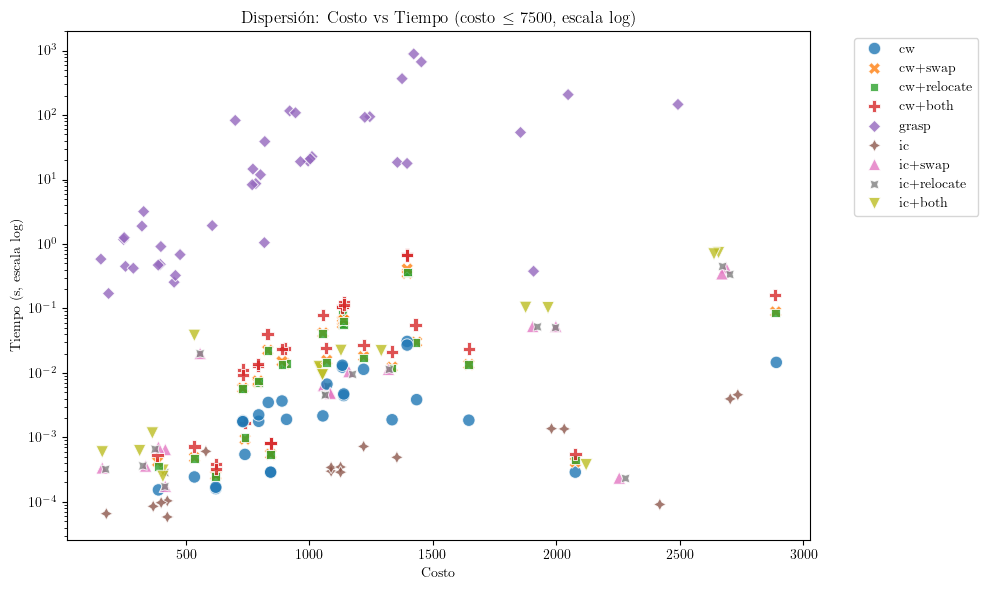

In [252]:
# Restringir los datos a costos < 7500 y tiempo < 25
filtered_df = df_ok[(df_ok['cost'] < 7500)]

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=filtered_df,
    x='cost',
    y='time',
    hue='combination',
    style='combination',
    alpha=0.8,
    s=80
)
ax.set_yscale('log')
plt.title('Dispersión: Costo vs Tiempo (costo $\leq$ 7500, escala log)')
plt.xlabel('Costo')
plt.ylabel('Tiempo (s, escala log)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/graficos/5.png', dpi=300)
plt.show()

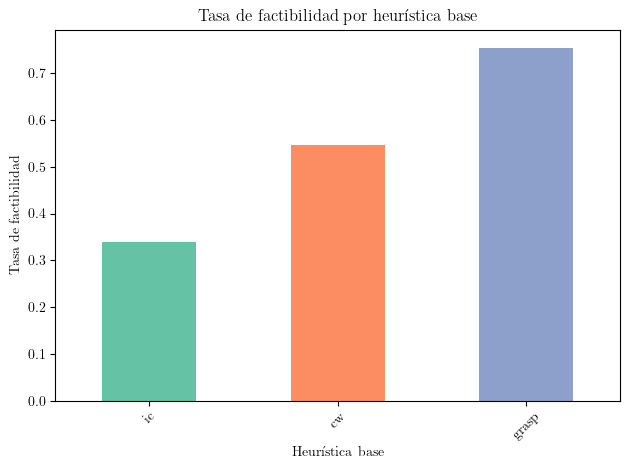

In [253]:
# Tasa de factibilidad por heurística base
import matplotlib.colors as mcolors

# Calcular la tasa de factibilidad por heurística base
tasa_factibilidad_por_heuristica = df.groupby('heuristic')['status'].apply(lambda x: (x == 'ok').mean())

# Ordenar la factibilidad por valor (de menor a mayor)
tasa_factibilidad_ordenada = tasa_factibilidad_por_heuristica.sort_values(ascending=True)
heuristicas_ordenadas = tasa_factibilidad_ordenada.index.tolist()

# Elegir una paleta de colores
paleta = sns.color_palette("Set2", n_colors=len(heuristicas_ordenadas))
heuristica_a_color = dict(zip(heuristicas_ordenadas, paleta))
colores_barras = [heuristica_a_color[h] for h in heuristicas_ordenadas]

tasa_factibilidad_ordenada.plot(kind='bar', color=colores_barras)
plt.title('Tasa de factibilidad por heurística base')
plt.ylabel('Tasa de factibilidad')
plt.xlabel('Heurística base')
plt.xticks(rotation=45)
# Agregar leyenda para las heurísticas (opcional, ya que el eje x son las heurísticas)
handles = [plt.Rectangle((0,0),1,1, color=heuristica_a_color[h]) for h in heuristicas_ordenadas]
plt.tight_layout()
plt.savefig('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/graficos/6.png', dpi=300)
plt.show()